# Objectives

## 1. Critical Month 
- For each of the 10 variables, compute monthly correlations (April–Oct) with yield.
- Rank months by correlation strength.
- Identify 3 most critical months where the variables show the strongest influence on yield.


## 2. Window Analysis
- Apply a 60-day rolling window across the growing season.
- For each window, compute correlations between yield and temperature and precipitation.
- Identify the single window (e.g., June–July) that best predicts yield using temperature and precipitation (use linear regression for prediction).


## 3. Yield–Weather Sensitivity 
- Compare critical windows across counties.
- Highlight whether yield is more sensitive to early-season stress (planting) or mid-season stress (growing).


# Critical Month

- For each of the 10 variables, compute monthly correlations (April–Oct) with yield.
- Rank months by correlation strength.
- Identify 3 most critical months where the variables show the strongest influence on yield.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

data_filepath = '../../Data/'
os.chdir(data_filepath)

data_files = [file for file in os.listdir("ds-capstone-dataset") if file[-4:] != '.csv']

avg_features = pd.read_csv("all_feature_data_avg.csv", index_col=0)

yield_pd = avg_features[["yield", "year", "year_index"]].copy()

yield_pd

In [9]:
# Testing how to get the correlation values with one feature variable

###########################################
'''
Load in file
'''
tmmx = np.load(f"ds-capstone-dataset/{data_files[0]}", allow_pickle=True)

tmmx_pd = pd.DataFrame(tmmx)

###########################################

# create empty df to store the monthly averages
month_avg = pd.DataFrame(index=tmmx_pd.index)

MONTHS = 30

# get monthly averages and store in above df
for i in range(7):
    month_avg[f"month_{i}"] = tmmx_pd.iloc[:, MONTHS*i:MONTHS*(i+1)].mean(axis=1)

# add in the yield data
month_avg['yield'] = yield_pd['yield']
month_avg['year'] = yield_pd['year']

correlation = month_avg.drop(['yield', 'year'], axis=1).corrwith(month_avg['yield'])

correlation

month_0   -0.001686
month_1   -0.006828
month_2   -0.029707
month_3   -0.060851
month_4   -0.049009
month_5    0.013046
month_6    0.003713
dtype: float64

In [11]:
'''
Flow: 
go through all of the feature variable dfs. have a global list that stores all of the correlation results. 
calculate the correlations as in the above cell. end up with a Series array
add the result to the global list
create a df out of the global list after finished with the for loop
'''

MONTHS = 30

avg_corr_list = []
corr = []
corr_labels = []

for data_file in data_files:
    f_var = np.load(f"ds-capstone-dataset/{data_file}", allow_pickle=True)
    feature = data_file[2:-19]
    f_var_df = pd.DataFrame(f_var)
    month_avg = pd.DataFrame(index=f_var_df.index)
    for i in range(7):
        month_avg[f"month_{i}"] = f_var_df.iloc[:, MONTHS*i:MONTHS*(i+1)].mean(axis=1)
    month_avg['yield'] = yield_pd['yield']
    month_avg['year'] = yield_pd['year']
    
    correlation = month_avg.drop(['yield', 'year'], axis=1).corrwith(month_avg['yield'])
    corr.append(correlation)

    corr_labels.append(feature)


corr_pd = pd.DataFrame(corr)
corr_pd.index = corr_labels
corr_pd.columns=["April", "May", "June", "July", "August", "September", "October"]

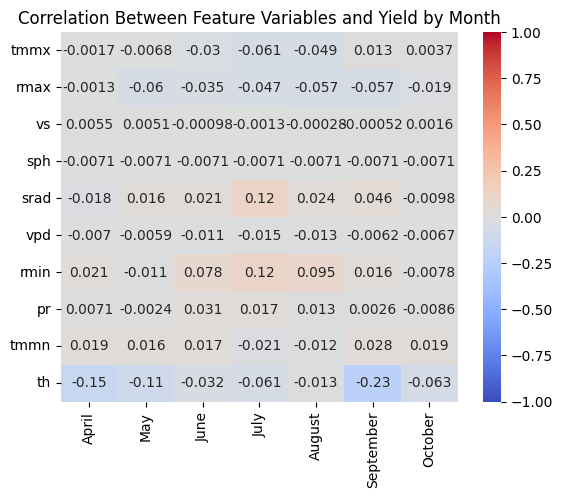

In [12]:
import seaborn as sns

sns.heatmap(
    corr_pd, 
    annot=True, 
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1
)
plt.title("Correlation Between Feature Variables and Yield by Month")
plt.show()

# Window Analysis
- Apply a 60-day rolling window across the growing season.
- For each window, compute correlations between yield and temperature and precipitation.
- Identify the single window (e.g., June–July) that best predicts yield using temperature and precipitation (use linear regression for prediction).

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler

data_filepath = '../../Data/'
#os.chdir(data_filepath)

data_files = [file for file in os.listdir("ds-capstone-dataset") if file[-4:] != '.csv']

avg_features = pd.read_csv("all_feature_data_avg.csv", index_col=0)

yield_pd = avg_features[["yield", "year", "year_index"]].copy()

data_files

['X_tmmx_1980_2018_rawyield',
 'X_rmax_1980_2018_rawyield',
 'X_vs_1980_2018_rawyield',
 'X_sph_1980_2018_rawyield',
 'X_srad_1980_2018_rawyield',
 'X_vpd_1980_2018_rawyield',
 'X_rmin_1980_2018_rawyield',
 'X_pr_1980_2018_rawyield',
 'X_tmmn_1980_2018_rawyield',
 'X_th_1980_2018_rawyield']

In [63]:
# only need temperature and precipitation

pr = np.load(f"ds-capstone-dataset/{data_files[-3]}", allow_pickle=True)
pr_df = pd.DataFrame(pr)

temp = np.load(f"ds-capstone-dataset/{data_files[0]}", allow_pickle=True)
temp_df = pd.DataFrame(temp)

labels=["May-June", "June-July", "July-August"]

MONTH = 30

pr_month = pd.DataFrame(index=pr_df.index)
temp_month = pd.DataFrame(index=temp_df.index)

for i in range(3):
    pr_month[i] = temp_df.iloc[:, MONTHS*(i+1):MONTHS*(i+3)].mean(axis=1)
    temp_month[i] = pr_df.iloc[:, MONTHS*(i+1):MONTHS*(i+3)].mean(axis=1)

pr_month.columns=labels
temp_month.columns=labels

pr_scaler = StandardScaler()
temp_scaler = StandardScaler()

scaled_array_pr = pr_scaler.fit_transform(pr_month)
pr_scaled = pd.DataFrame(scaled_array_pr, columns=pr_month.columns)

scaled_array_temp = temp_scaler.fit_transform(temp_month)
temp_scaled = pd.DataFrame(scaled_array_temp, columns=temp_month.columns)

pr_scaled['yield'] = yield_pd['yield']
temp_scaled['yield'] = yield_pd['yield']

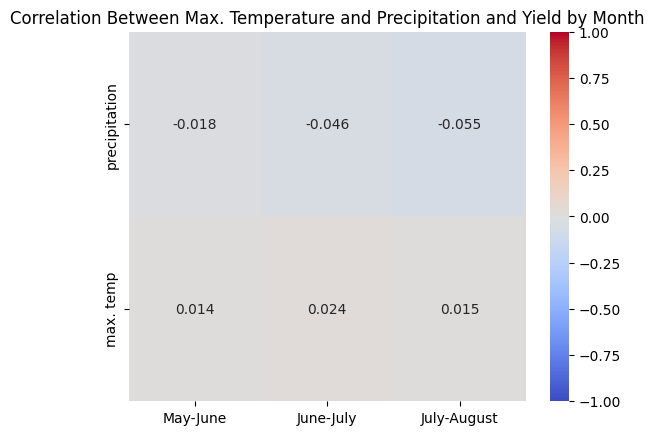

In [64]:
pr_corr = pr_scaled.drop(['yield'], axis=1).corrwith(pr_scaled['yield'])
temp_corr = temp_scaled.drop(['yield'], axis=1).corrwith(temp_scaled['yield'])

pr_and_temp_corr = pd.DataFrame([pr_corr, temp_corr], index=["precipitation", "max. temp"])

sns.heatmap(
    pr_and_temp_corr, 
    annot=True, 
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1
)
plt.title("Correlation Between Max. Temperature and Precipitation and Yield by Month")
plt.show()

In [68]:
may_june = pd.DataFrame([pr_scaled["May-June"], temp_scaled["May-June"]], index=["temp", "pr"]).T
may_june = may_june.replace(0, 1e-4) # replace 0s with a small epsilon to avoid divide by zero errors

june_july = pd.DataFrame([pr_scaled["June-July"], temp_scaled["June-July"]], index=["temp", "pr"]).T
june_july = june_july.replace(0, 1e-4)

july_august = pd.DataFrame([pr_scaled["July-August"], temp_scaled["July-August"]], index=["temp", "pr"]).T
july_august = july_august.replace(0, 1e-4)

In [88]:
from sklearn.linear_model import LinearRegression

y = yield_pd['yield']

may_june_model = LinearRegression()
may_june_model.fit(may_june, y)
m_j_y_pred = may_june_model.predict(may_june)

june_july_model = LinearRegression()
june_july_model.fit(june_july, y)
j_j_y_pred = june_july_model.predict(june_july)

july_august_model = LinearRegression()
july_august_model.fit(july_august, y)
j_a_y_pred = july_august_model.predict(july_august)

/Users/katiebaek/Downloads/Crop-Yield-Prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/katiebaek/Downloads/Crop-Yield-Prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/katiebaek/Downloads/Crop-Yield-Prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/katiebaek/Downloads/Crop-Yield-Prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/katiebaek/Downloads/Crop-Yield-Prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ +

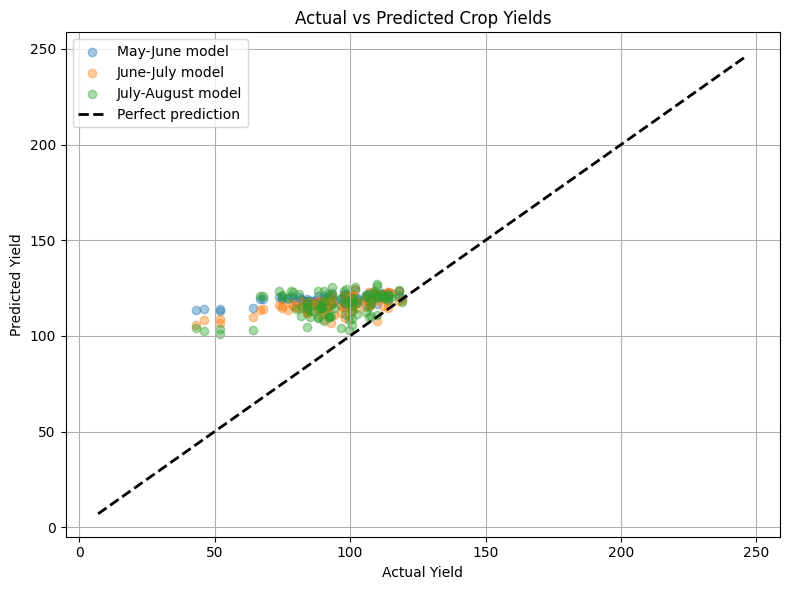

In [93]:
plt.figure(figsize=(8,6))

plt.scatter(y[100:200], m_j_y_pred[100:200], alpha=0.4, label="May-June model")
plt.scatter(y[100:200], j_j_y_pred[100:200], alpha=0.4, label="June-July model")
plt.scatter(y[100:200], j_a_y_pred[100:200], alpha=0.4, label="July-August model")

# Add a 1:1 reference line
lims = [y.min(), y.max()]
plt.plot(lims, lims, 'k--', linewidth=2, label="Perfect prediction")

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Crop Yields")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Yield–Weather Sensitivity 
- Compare critical windows across counties.
- Highlight whether yield is more sensitive to early-season stress (planting) or mid-season stress (growing).

# Getting Growing Season Averages

- Already ran and uploaded files to Github. Does not need to be repeated

In [18]:
import pandas as pd
import numpy as np
import os

data_filepath = '../../Data/ds-capstone-dataset'
os.chdir(data_filepath)

data_files = [file for file in os.listdir(data_filepath) if file[-4:] != '.csv']

labels = pd.read_csv(f"label_1980_2018_rawyield.csv")

# Rename first column
labels = labels.rename(columns={"Unnamed: 0":"year_index"})

thirds = 70

print(data_files)

['X_tmmx_1980_2018_rawyield', 'X_rmax_1980_2018_rawyield', 'X_vs_1980_2018_rawyield', 'X_sph_1980_2018_rawyield', 'X_srad_1980_2018_rawyield', 'X_vpd_1980_2018_rawyield', 'X_rmin_1980_2018_rawyield', 'X_pr_1980_2018_rawyield', 'X_tmmn_1980_2018_rawyield', 'X_th_1980_2018_rawyield']


In [33]:
for file in data_files:
    feature = file[2:-19]
    data = np.load(f'{data_filepath}/{file}', allow_pickle=True)
    data_df = pd.DataFrame(data)
    cols1 = data_df.iloc[:, :thirds]
    cols2 = data_df.iloc[:, thirds:2*thirds]
    cols3 = data_df.iloc[:, 2*thirds:] 
    feature_growing_phases = pd.DataFrame({
        'germination': cols1.mean(axis=1),
        'growth': cols2.mean(axis=1),
        'maturity': cols3.mean(axis=1)
    })
    feature_growing_phases.to_csv(f"../{feature}_avg_growing_phase.csv")

